In [1]:
# -------------------------------
# Cell 1: Imports & Device
# -------------------------------
import os
import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


c:\Users\Mayank Kandari\Desktop\ADM proj\EfficientNet\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# -------------------------------
# Cell 2: Dataset & Dataloader
# -------------------------------
NUM_CLASSES = 35
BATCH_SIZE = 16
DATA_DIR = Path("dataset")

# Transforms
val_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Datasets
val_clean_dataset = datasets.ImageFolder(DATA_DIR/"val/clean", transform=val_transforms)
val_noisy_dataset = datasets.ImageFolder(DATA_DIR/"val/noisy", transform=val_transforms)
test_clean_dataset = datasets.ImageFolder(DATA_DIR/"test/clean", transform=val_transforms)
test_noisy_dataset = datasets.ImageFolder(DATA_DIR/"test/noisy", transform=val_transforms)

# Dataloaders
val_clean_loader = DataLoader(val_clean_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_noisy_loader = DataLoader(val_noisy_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_clean_loader = DataLoader(test_clean_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_noisy_loader = DataLoader(test_noisy_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Validation clean samples: {len(val_clean_dataset)}, noisy samples: {len(val_noisy_dataset)}")
print(f"Test clean samples: {len(test_clean_dataset)}, noisy samples: {len(test_noisy_dataset)}")

Validation clean samples: 2800, noisy samples: 2800
Test clean samples: 1400, noisy samples: 1400


In [3]:
# -------------------------------
# Cell 3: Load Fine-tuned Model
# -------------------------------
model = models.efficientnet_b0(pretrained=False)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features, NUM_CLASSES)
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()
print("Fine-tuned model loaded for evaluation.")

Fine-tuned model loaded for evaluation.


c:\Users\Mayank Kandari\Desktop\ADM proj\EfficientNet\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mayank Kandari\Desktop\ADM proj\EfficientNet\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# -------------------------------
# Cell 4: Helper - get predictions & probs
# -------------------------------
def get_predictions(model, loader, device):
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Predicting"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [5]:
# -------------------------------
# Cell 5: Compute Metrics Function
# -------------------------------
def compute_metrics(y_true, y_pred, y_prob):
    metrics = {}

    # Accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 (macro)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1'] = f1

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    # ROC-AUC (one-vs-rest)
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    try:
        metrics['roc_auc_macro'] = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
    except:
        metrics['roc_auc_macro'] = None  # fallback if not computable

    return metrics

In [6]:
# -------------------------------
# Cell 5b: FAR/FRR/EER computation
# -------------------------------
from sklearn.metrics import roc_curve

def compute_far_frr_eer(y_true, y_prob, num_classes=35):
    """
    Compute FAR, FRR, and EER per class using one-vs-rest approach.
    y_true: true labels
    y_prob: probability predictions (softmax)
    """
    far_dict = {}
    frr_dict = {}
    eer_dict = {}
    
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    for cls in range(num_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, cls], y_prob[:, cls])
        fnr = 1 - tpr
        
        # EER: threshold where FAR ≈ FRR
        eer_idx = np.nanargmin(np.abs(fpr - fnr))
        eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
        
        far_dict[cls] = fpr[eer_idx]
        frr_dict[cls] = fnr[eer_idx]
        eer_dict[cls] = eer
        
    return far_dict, frr_dict, eer_dict


In [7]:
# -------------------------------
# Cell 6: Evaluate Clean & Noisy
# -------------------------------
# Validation
val_clean_labels, val_clean_preds, val_clean_probs = get_predictions(model, val_clean_loader, device)
val_noisy_labels, val_noisy_preds, val_noisy_probs = get_predictions(model, val_noisy_loader, device)

# Test
test_clean_labels, test_clean_preds, test_clean_probs = get_predictions(model, test_clean_loader, device)
test_noisy_labels, test_noisy_preds, test_noisy_probs = get_predictions(model, test_noisy_loader, device)

# Metrics
val_clean_metrics = compute_metrics(val_clean_labels, val_clean_preds, val_clean_probs)
val_noisy_metrics = compute_metrics(val_noisy_labels, val_noisy_preds, val_noisy_probs)

test_clean_metrics = compute_metrics(test_clean_labels, test_clean_preds, test_clean_probs)
test_noisy_metrics = compute_metrics(test_noisy_labels, test_noisy_preds, test_noisy_probs)


Predicting: 100%|██████████| 88/88 [00:48<00:00,  1.82it/s]


In [8]:
def evaluate_and_print(y_true, y_pred, y_prob, split_name="Split"):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    # ROC-AUC (one-vs-rest)
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    try:
        roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
    except:
        roc_auc = None

    # FAR/FRR/EER
    far_dict, frr_dict, eer_dict = compute_far_frr_eer(y_true, y_prob, num_classes=NUM_CLASSES)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print summary
    print(f"\n--- {split_name} Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC (macro, one-vs-rest): {roc_auc:.4f}")

    # FAR/FRR/EER summary
    avg_far = np.mean(list(far_dict.values()))
    avg_frr = np.mean(list(frr_dict.values()))
    avg_eer = np.mean(list(eer_dict.values()))
    print(f"Average FAR: {avg_far:.4f}, Average FRR: {avg_frr:.4f}, Average EER: {avg_eer:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "far": far_dict,
        "frr": frr_dict,
        "eer": eer_dict,
        "confusion_matrix": cm  # ✅ add confusion matrix here
    }


In [9]:
# -------------------------------
# Cell 7b: Run evaluation on all datasets
# -------------------------------

# Validation
val_clean_metrics = evaluate_and_print(val_clean_labels, val_clean_preds, val_clean_probs, split_name="Validation Clean")
val_noisy_metrics = evaluate_and_print(val_noisy_labels, val_noisy_preds, val_noisy_probs, split_name="Validation Noisy")

# Test
test_clean_metrics = evaluate_and_print(test_clean_labels, test_clean_preds, test_clean_probs, split_name="Test Clean")
test_noisy_metrics = evaluate_and_print(test_noisy_labels, test_noisy_preds, test_noisy_probs, split_name="Test Noisy")

# Noise Robustness
val_robustness = val_noisy_metrics['accuracy'] / val_clean_metrics['accuracy']
test_robustness = test_noisy_metrics['accuracy'] / test_clean_metrics['accuracy']
print(f"\nValidation Robustness Score: {val_robustness:.4f}")
print(f"Test Robustness Score: {test_robustness:.4f}")



--- Validation Clean Metrics ---
Accuracy: 0.9104
Precision (macro): 0.9120
Recall (macro): 0.9104
F1 Score (macro): 0.9103
ROC-AUC (macro, one-vs-rest): 0.9970
Average FAR: 0.0239, Average FRR: 0.0246, Average EER: 0.0243

--- Validation Noisy Metrics ---
Accuracy: 0.8911
Precision (macro): 0.8938
Recall (macro): 0.8911
F1 Score (macro): 0.8912
ROC-AUC (macro, one-vs-rest): 0.9961
Average FAR: 0.0271, Average FRR: 0.0286, Average EER: 0.0278

--- Test Clean Metrics ---
Accuracy: 0.9029
Precision (macro): 0.9055
Recall (macro): 0.9029
F1 Score (macro): 0.9028
ROC-AUC (macro, one-vs-rest): 0.9977
Average FAR: 0.0206, Average FRR: 0.0214, Average EER: 0.0210

--- Test Noisy Metrics ---
Accuracy: 0.8771
Precision (macro): 0.8795
Recall (macro): 0.8771
F1 Score (macro): 0.8765
ROC-AUC (macro, one-vs-rest): 0.9961
Average FAR: 0.0317, Average FRR: 0.0300, Average EER: 0.0309

Validation Robustness Score: 0.9788
Test Robustness Score: 0.9715


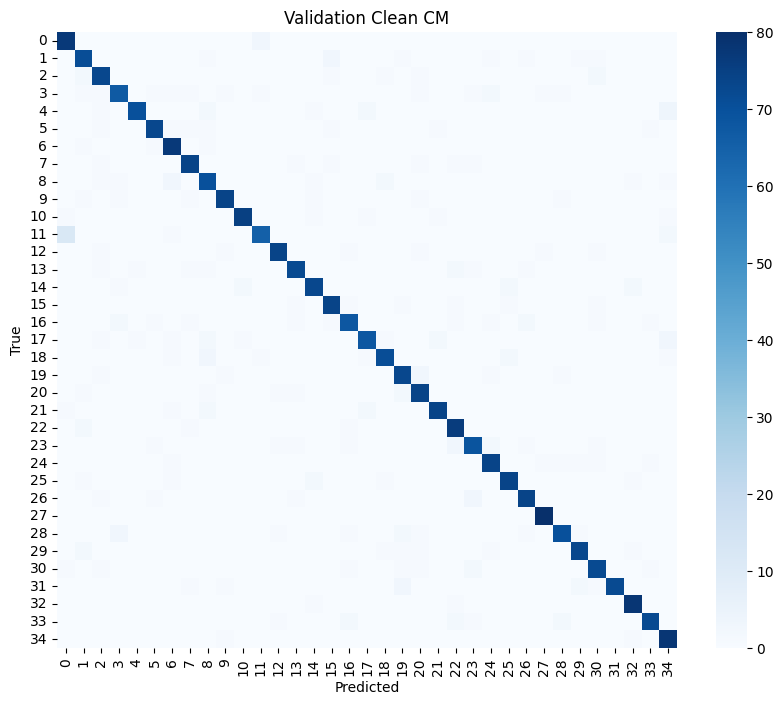

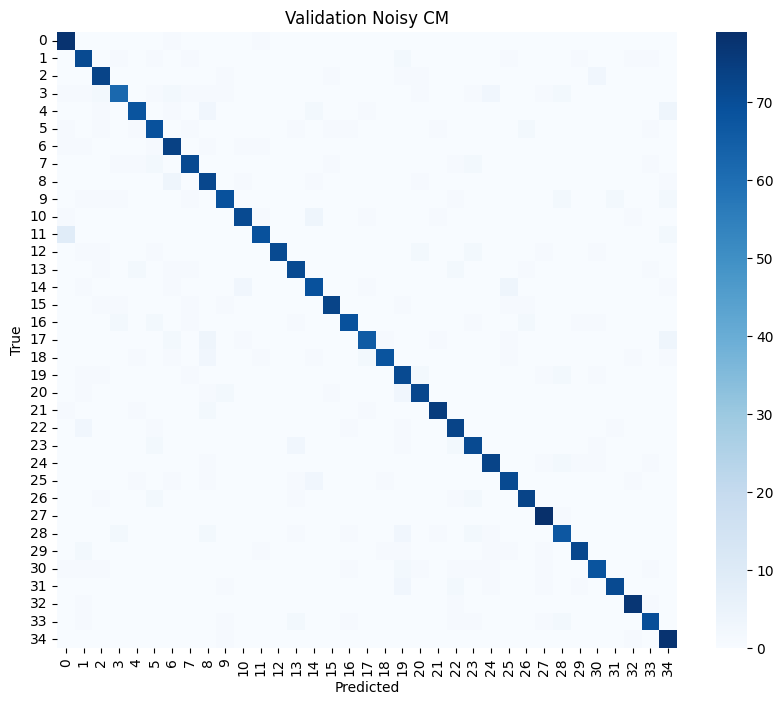

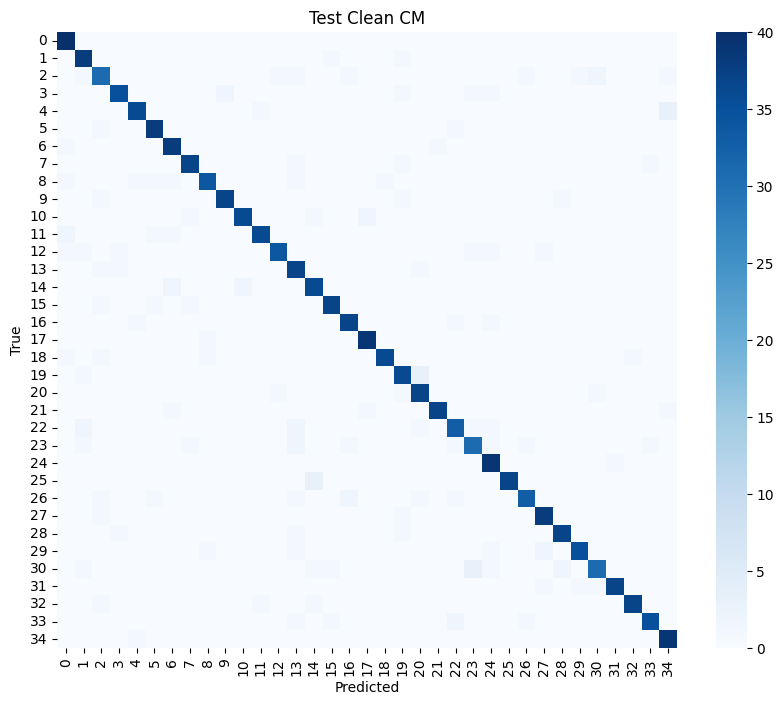

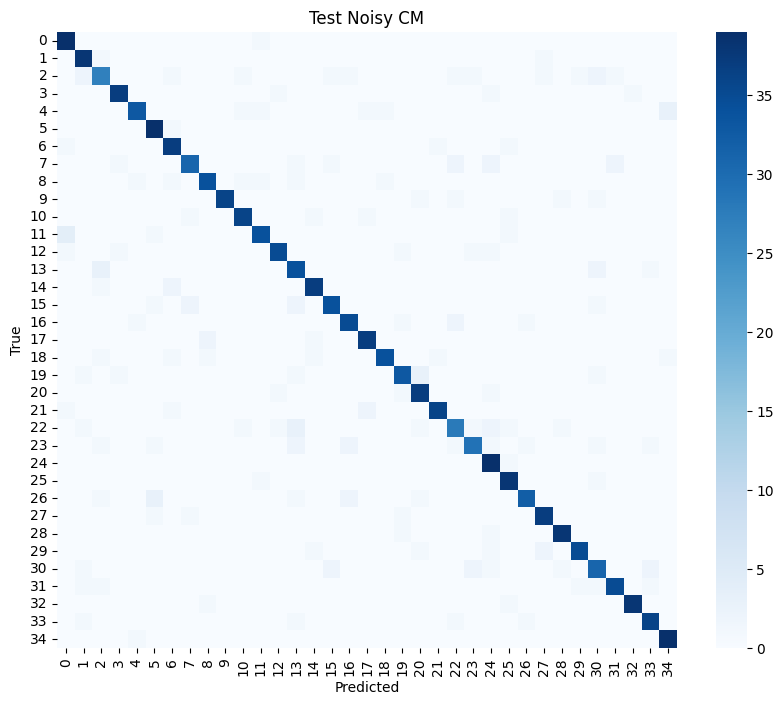

In [11]:
# -------------------------------
# Cell 8: Confusion Matrix Plot
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    if class_names is not None:
        plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=90)
        plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=0)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot examples
plot_confusion_matrix(val_clean_metrics['confusion_matrix'], title="Validation Clean CM")
plot_confusion_matrix(val_noisy_metrics['confusion_matrix'], title="Validation Noisy CM")
plot_confusion_matrix(test_clean_metrics['confusion_matrix'], title="Test Clean CM")
plot_confusion_matrix(test_noisy_metrics['confusion_matrix'], title="Test Noisy CM")


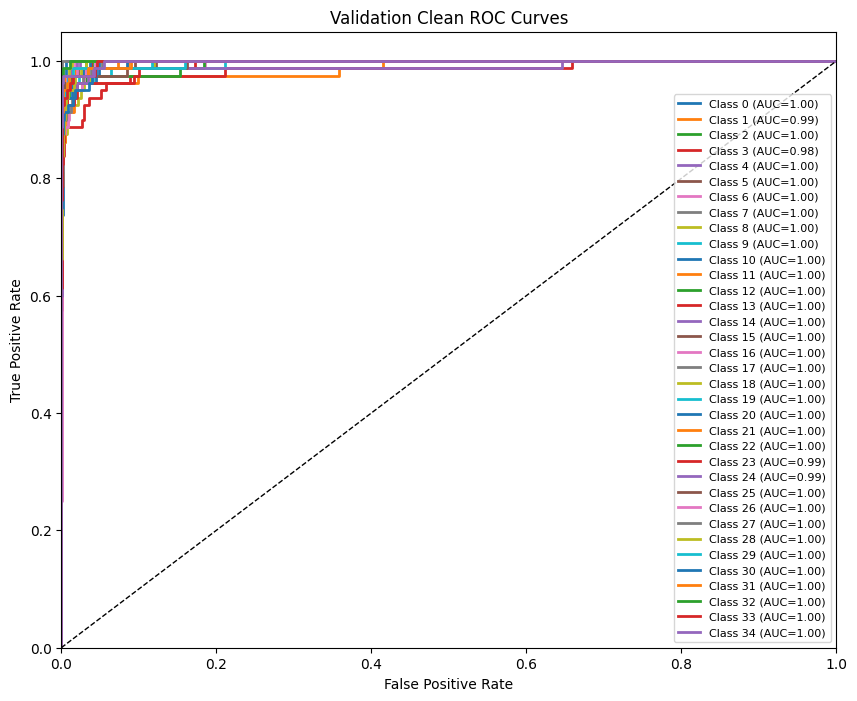

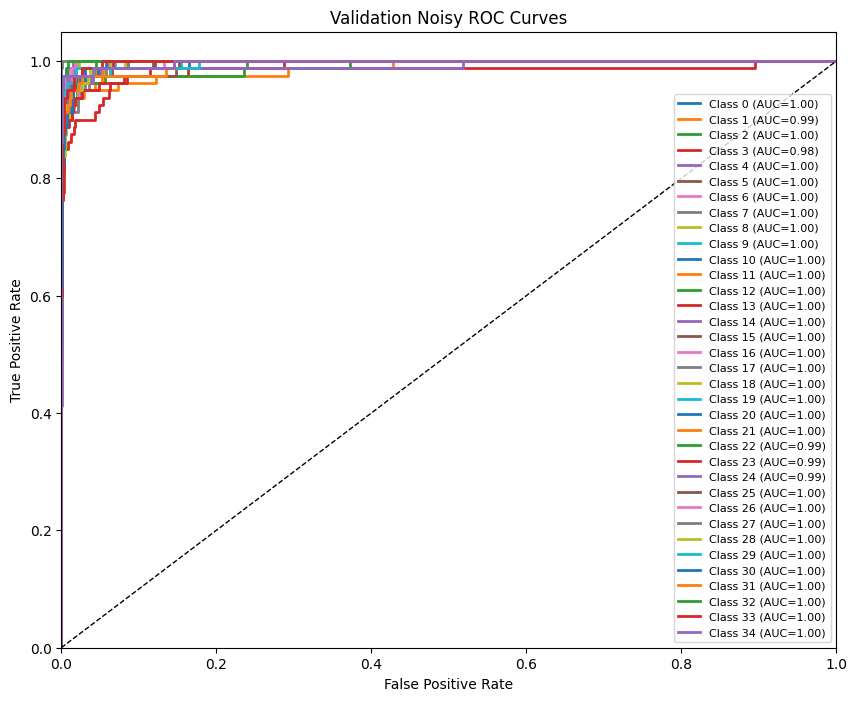

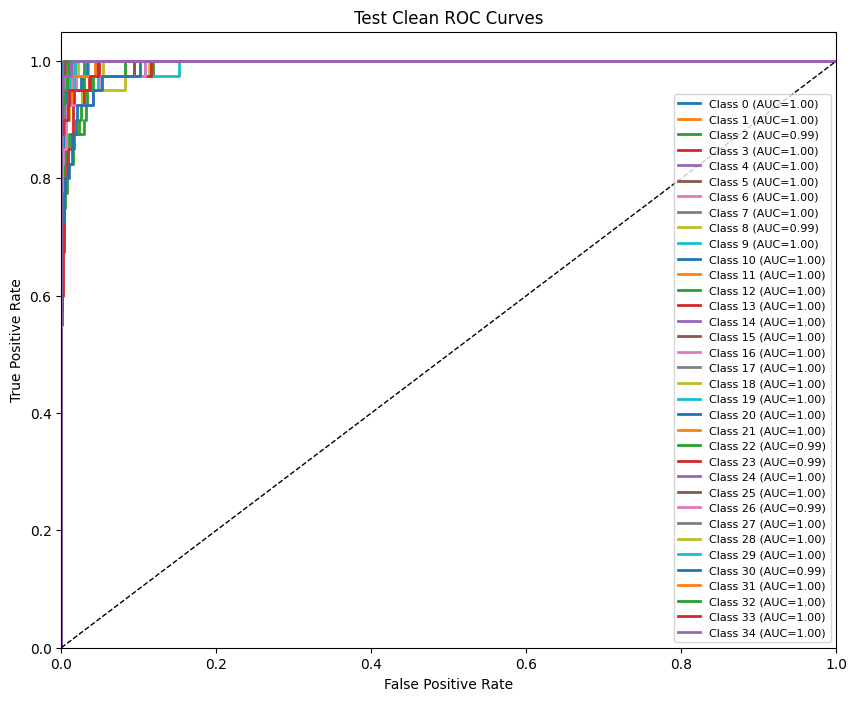

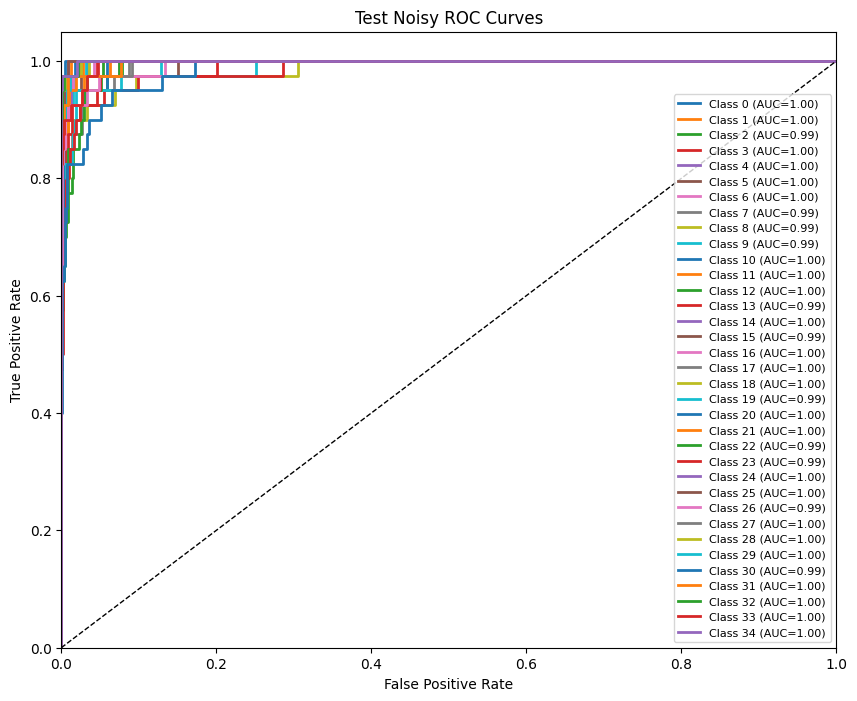

In [13]:
# -------------------------------
# Cell 9: ROC Curves
# -------------------------------
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_prob, num_classes=NUM_CLASSES, title="ROC Curve"):
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(10,8))
    for cls in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, cls], y_prob[:, cls])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right", fontsize=8)
    plt.show()

# Example: Validation
plot_roc(val_clean_labels, val_clean_probs, title="Validation Clean ROC Curves")
plot_roc(val_noisy_labels, val_noisy_probs, title="Validation Noisy ROC Curves")
plot_roc(test_clean_labels, test_clean_probs, title="Test Clean ROC Curves")
plot_roc(test_noisy_labels, test_noisy_probs, title="Test Noisy ROC Curves")


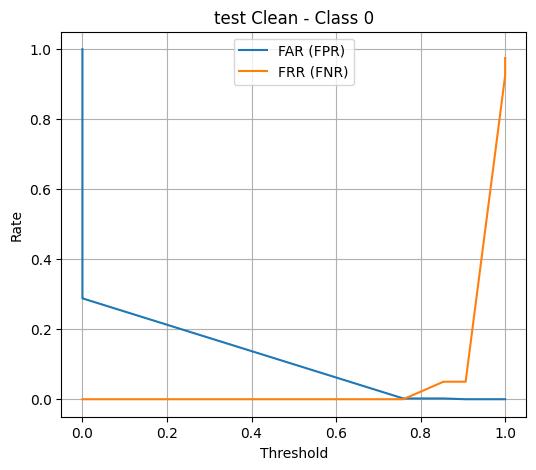

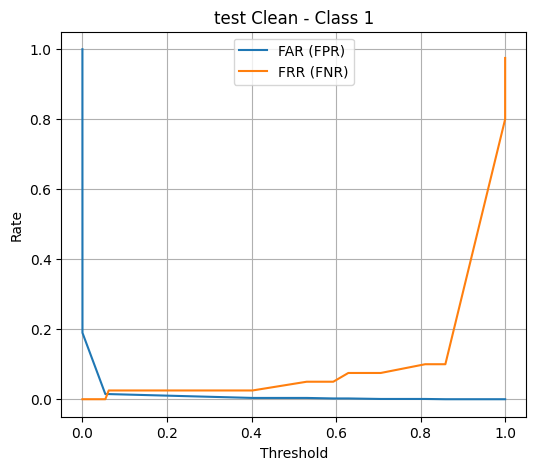

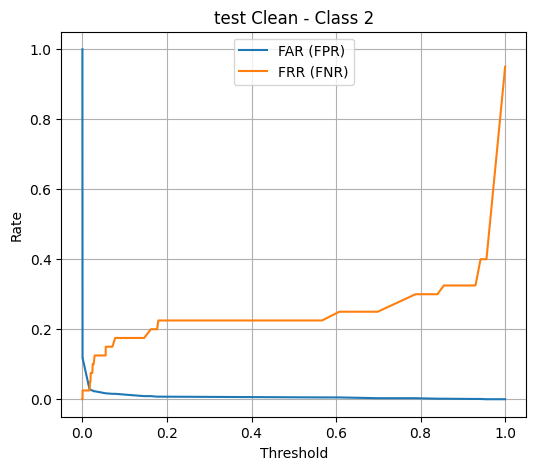

In [15]:
# -------------------------------
# Cell 10: FAR/FRR Curves
# -------------------------------
def plot_far_frr(y_true, y_prob, class_idx, title="FAR/FRR Curve"):
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, class_idx], y_prob[:, class_idx])
    fnr = 1 - tpr

    plt.figure(figsize=(6,5))
    plt.plot(thresholds, fpr, label="FAR (FPR)")
    plt.plot(thresholds, fnr, label="FRR (FNR)")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title(f"{title} - Class {class_idx}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: plot for first 3 classes
for cls in range(3):
    plot_far_frr(test_clean_labels, test_clean_probs, cls, title="test Clean")
